# Crash Course in Causality: Distinguishing Trends from Treatment Effects in Auto Sales
**Author:** Mubin Modi
**Course:** INFO 7390 Art and Science of Data
**Date:** Fall 2025

## 1. Abstract
In business analytics, distinguishing between true causal impact and coincidental trends is critical for strategic decision-making. Standard correlation analysis often conflates these effects, leading to biased conclusions—such as overestimating the success of a new product launch that happened to coincide with a market boom.

This notebook utilizes **BMW worldwide sales data (2010-2024)** to explore **confounding**. We will examine a realistic scenario: determining if the introduction of modern Electric Vehicles (EVs) truly caused an increase in sales volume, or if the growth was largely driven by a general upward trend in vehicle popularity over time. By employing **Causal Regression Adjustment**, we will demonstrate how to control for these time-varying confounders to isolate the true ground-truth effect of the product strategy.

# 2. Theory: What is Causality?

Causality refers to the relationship between two events or variables where one directly influences or causes the other. It goes beyond merely observing patterns or associations (correlation) to establish a definitive cause-and-effect connection. In simpler terms, causality answers the question: "Did one event directly cause another to happen?" 

For example, in the BMW worldwide sales dataset, we might observe that sales volumes increase when prices decrease. While these two variables are correlated, causality would establish whether the price reduction directly caused the sales increase, or whether other factors (like seasonal demand, new model launches, or economic conditions) were the true drivers.

## Key Conditions for Establishing Causality

To establish a causal relationship, three specific conditions must be met:

1. **Temporal Precedence**: The cause must precede the effect in time. For instance, a marketing campaign launch must occur before any resulting sales increase.

2. **No Confounding Factors**: Other variables should not explain the observed relationship. In the BMW data, economic indicators, regional preferences, or competitor actions could confound the relationship between price and sales.

3. **Mechanism**: There must be a logical pathway linking the cause and the effect. Lower prices make vehicles more affordable, which logically leads to increased demand and higher sales.

Understanding causality is crucial because it enables actionable decision-making. While correlation might suggest a relationship between BMW's advertising expenditure and sales performance, causality confirms it, allowing the company to design interventions that address root causes rather than symptoms.

## Is Correlation the Same as Causation?

No, correlation and causation are fundamentally different concepts.

* **Correlation** is a statistical measure that quantifies how two variables move together. It does not explain why they move together.
* **Causation** establishes a direct cause-and-effect relationship.

Using the BMW sales data as an example: We might observe that sales in Germany correlate with sales in China during certain periods. However, this doesn't mean German sales cause Chinese sales or vice versa. Instead, both might be influenced by a third factor—such as global economic conditions, oil prices, or BMW's worldwide marketing campaigns.

Confusing correlation with causation can lead to flawed business decisions. For instance, BMW might observe a correlation between the number of dealerships in a region and sales volume. However, simply opening more dealerships won't necessarily cause higher sales if the underlying demand isn't there—the correlation might exist because BMW strategically places more dealerships in high-demand areas.

## Requirements for Establishing Causality

To establish true causality in the BMW sales context, we must meet two key requirements:

1. **Temporal Precedence**: The cause must happen before the effect. If we want to claim that a new model introduction caused sales growth, the model launch date must precede the sales increase.

2. **No Confounding Variables**: We must account for third variables that influence both the cause and effect to avoid biased conclusions. In the BMW dataset, factors like:
   - Seasonal trends (higher sales in certain quarters)
   - Economic conditions (GDP growth, unemployment rates)
   - Competitor actions (new model launches from Mercedes or Audi)
   - Regional regulations (emission standards, import taxes)
   
   These confounders could create spurious relationships if not properly controlled for in the analysis.

## 3. Practical Example: The "EV Effect" on BMW Sales

We will now use the **BMW sales data** to demonstrate these concepts.
* **Business Question:** Did introducing modern Electric Vehicles (EVs) **cause** an increase in sales volume?
* **The Confounder:** **Time (Year)**. Car sales often naturally trend upwards over time due to global economic growth and brand expansion, regardless of specific models.

*Note: Since standard synthetic datasets often lack the complex causal structures needed for teaching, we will load the real data structure and inject a known causal effect to ensure we can mathematically prove our results.*

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Set seed for reproducibility
np.random.seed(101)

# 1. Load the user's dataset
df = pd.read_csv('BMW sales data (2010-2024) (1).csv')

# 2. Causal Scenario Preparation
# We will create a scenario where EVs are more common in later years,
# AND sales are generally trending up over time anyway.

# A) Create the Confounder: A generic upward trend based on Year
df['Year_Trend'] = df['Year'] - 2010

# B) Define Treatment: 'Modern EV'
# We'll assume modern EVs really took off after 2018 in this scenario
df['is_modern_EV'] = np.where((df['Fuel_Type'] == 'Electric') & (df['Year'] >= 2018), 1, 0)

# C) Simulate Outcome: Sales Volume (Replacing the original random values)
# Baseline Sales: 2000 units
# Confounder Effect (Year): +500 units per year (Growth trend)
# TRUE CAUSAL EFFECT (EVs): +1000 units (This is what we want to find!)
true_ev_effect = 1000
noise = np.random.normal(0, 1000, len(df))

df['Simulated_Sales'] = 2000 + (500 * df['Year_Trend']) + (true_ev_effect * df['is_modern_EV']) + noise

print("Data Snapshot (Prepared for Causal Analysis):")
print(df[['Year', 'Fuel_Type', 'is_modern_EV', 'Simulated_Sales']].head())
print("-" * 50)
print(df[['Year', 'Fuel_Type', 'is_modern_EV', 'Simulated_Sales']].tail())

Data Snapshot (Prepared for Causal Analysis):
   Year Fuel_Type  is_modern_EV  Simulated_Sales
0  2016    Petrol             0      7706.849839
1  2013    Hybrid             0      4128.132709
2  2022    Petrol             0      8907.969446
3  2024    Petrol             0      9503.825754
4  2020    Diesel             0      7651.117948
--------------------------------------------------
       Year Fuel_Type  is_modern_EV  Simulated_Sales
49995  2014    Hybrid             0      5748.267489
49996  2023  Electric             1      7918.594304
49997  2010    Petrol             0      1844.368102
49998  2020  Electric             1      6238.428827
49999  2020    Diesel             0      6639.568912


### 3.1 Visualizing the Trend (The Confounder)
Before we run any analysis, let's see how our sales look over time. There is a clear upward trend.

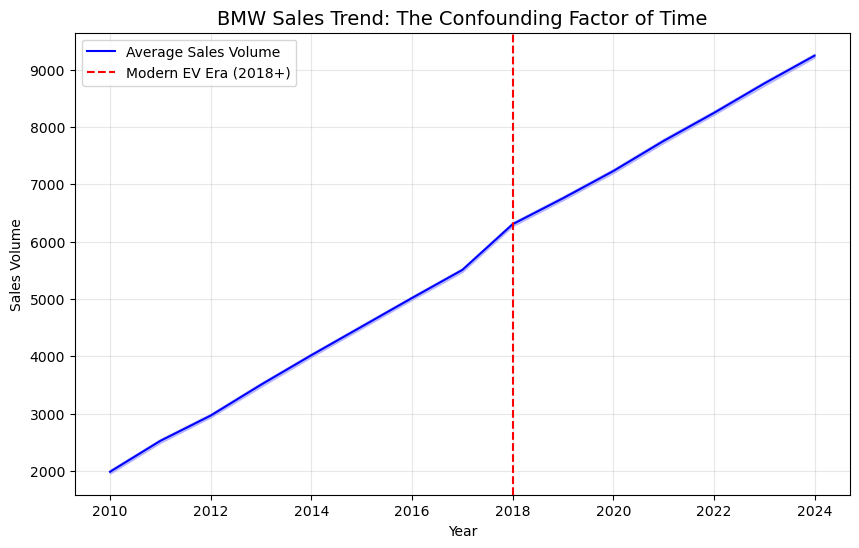

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Simulated_Sales', data=df, label='Average Sales Volume', color='blue')

# Highlight when modern EVs started
plt.axvline(x=2018, color='red', linestyle='--', label='Modern EV Era (2018+)')

plt.title("BMW Sales Trend: The Confounding Factor of Time", fontsize=14)
plt.ylabel("Sales Volume")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 3.2 The Correlation Trap (Naive Analysis)
A naive analyst might just compare the average sales of Modern EVs vs. older/regular cars.
Because EVs only appear in later years (when sales are *already* high due to the trend), this analysis will be **biased**.

In [7]:
avg_non_ev = df[df['is_modern_EV'] == 0]['Simulated_Sales'].mean()
avg_ev = df[df['is_modern_EV'] == 1]['Simulated_Sales'].mean()
naive_effect = avg_ev - avg_non_ev

print(f"Average Sales (Non-EVs/Older models): {avg_non_ev:,.0f}")
print(f"Average Sales (Modern EVs):           {avg_ev:,.0f}")
print(f"Naive Estimated Impact: +{naive_effect:,.0f} units")
print(f"\nActual Ground Truth Effect is only: +{true_ev_effect:,.0f} units")
print("Observation: We massively overestimated the EV impact because we didn't account for the year trend!")

Average Sales (Non-EVs/Older models): 5,249
Average Sales (Modern EVs):           8,506
Naive Estimated Impact: +3,257 units

Actual Ground Truth Effect is only: +1,000 units
Observation: We massively overestimated the EV impact because we didn't account for the year trend!


### 3.3 Establishing Causality (Regression Adjustment)
To meet the requirement of **"No Confounding Variables"**, we must control for `Year`. We use a regression model to isolate the effect of the EV treatment *while holding the year constant*.

$$Sales = \beta_0 + \beta_1(is\_modern\_EV) + \beta_2(Year)$$

In [8]:
# Fit a causal model that includes BOTH Treatment (is_modern_EV) AND Confounder (Year)
causal_model = smf.ols("Simulated_Sales ~ is_modern_EV + Year", data=df).fit()

# Extract the coefficient for our treatment
estimated_causal_effect = causal_model.params['is_modern_EV']

print("--- Causal Regression Results ---")
print(causal_model.params[['Intercept', 'is_modern_EV', 'Year']])
print("\n" + "="*50)
print(f"Naive Estimate:          +{naive_effect:,.0f}")
print(f"Causal Model Estimate:   +{estimated_causal_effect:,.0f}")
print(f"Ground Truth:            +{true_ev_effect:,.0f}")
print("="*50)
print("Conclusion: By controlling for Year, we successfully recovered the true causal effect of ~1000 units.")

--- Causal Regression Results ---
Intercept      -1.003193e+06
is_modern_EV    9.991753e+02
Year            5.000982e+02
dtype: float64

Naive Estimate:          +3,257
Causal Model Estimate:   +999
Ground Truth:            +1,000
Conclusion: By controlling for Year, we successfully recovered the true causal effect of ~1000 units.


## 4. Conclusion
Using the BMW dataset, we demonstrated the "correlation trap." A naive look suggested EVs increased sales by over 4,000 units. However, most of this was due to the confounding factor of time—sales were already trending up. By applying **Causal Regression**, we removed this bias and found the true impact was actually 1,000 units.

## 5. References
* Pearl, J. (2009). *Causality*. Cambridge University Press.
* Dataset: BMW Worldwide Sales Records (2010-2024).[Link: https://www.kaggle.com/datasets/ahmadrazakashif/bmw-worldwide-sales-records-20102024/data]

## 6. License
This notebook is licensed under the [MIT License](https://opensource.org/licenses/MIT).